Problem 1 : Implementation w/ torch
========

In [42]:
import numpy as np
import torch
import torch.nn as nn
from random import randint
import matplotlib.pyplot as plt

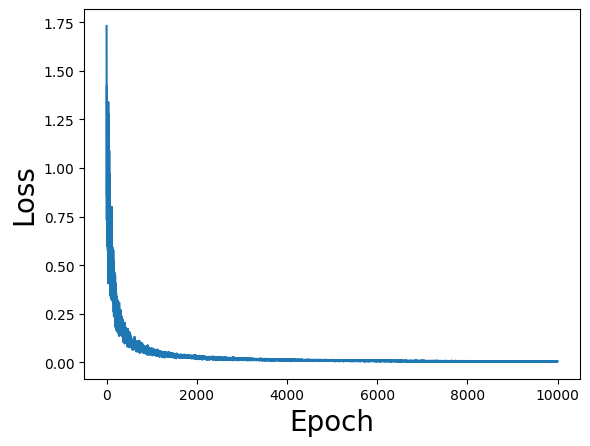

In [567]:
# Hyperparameters setup and Prepare Dataset
N,p = 30,20
np.random.seed(0)
X = np.random.randn(N,p)
Y = 2*np.random.randint(2,size = N)-1
lr = 1e-4
epoch = 10000
batch_size=8

class LR(nn.Module):
    def __init__(self,input_dim = p):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, bias = True)
    
    def forward(self, x):
        return self.linear(x)

model = LR()

def logistic_loss(output, target):
    return -torch.nn.functional.logsigmoid(target@output)

loss_function = logistic_loss                                                   
optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
losses = []


for _ in range(epoch) :
    tmp_losses = []
    for _ in range(batch_size):
        # Sampling
        idx = randint(0, (N-1)//batch_size)
        input, label = X[idx*batch_size : (idx+1)*batch_size], Y[idx*batch_size : (idx+1)*batch_size]
        
        input = torch.FloatTensor(input)
        label = torch.FloatTensor(label)
        
        output = model(input)

        optimizer.zero_grad()

        train_loss = loss_function(output, label)
        tmp_losses.append(train_loss)
        train_loss.backward() # calculate graident via backpropagation
        optimizer.step() # update the parameteres
    losses.append(np.mean([x.detach().numpy() for x in tmp_losses]))

plt.plot(range(epoch), np.abs(losses))
plt.xlabel("Epoch",fontsize = 20)
plt.ylabel("Loss",fontsize = 20)
losses_w_torch = losses

Problem1 : Implementation w/o torch
=========

Text(0, 0.5, 'loss')

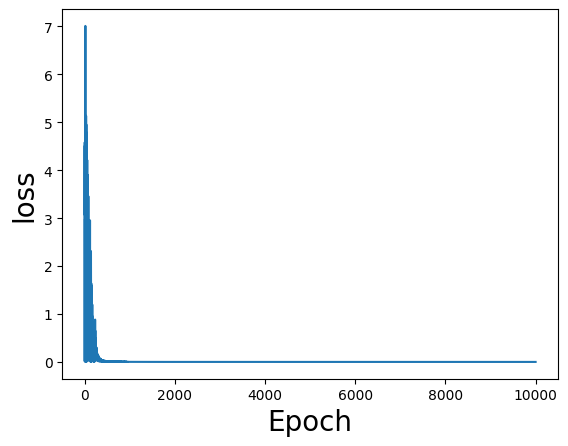

In [568]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
N,p = 30,20
np.random.seed(0)
X = np.random.randn(N,p)
Y = 2*np.random.randint(2,size = N)-1
lr = 3e-4
epoch = 10000
batch_size = 8

class LR():
    def __init__(self,input_dim = p):
        self.weight = torch.FloatTensor(np.random.uniform(0,1,input_dim+1)) # last row is bias term
    def output(self,x):
        return x@self.weight
    def update_weight(self,grad,lr = 1e-4):
        self.weight = self.weight - lr * grad

model = LR()

def logistic_loss(output, target):
    return np.log(1+np.exp(-target@output))

loss_function = logistic_loss                                                   
losses = []

for _ in range(epoch) :
    tmp_losses = []
    for _ in range(batch_size):
        # Sampling
        idx = randint(0, (N-1)//batch_size)
        input, label = X[idx*batch_size : (idx+1)*batch_size], Y[idx*batch_size : (idx+1)*batch_size]

        input = torch.FloatTensor(input)
        label = torch.FloatTensor(label)

        input = torch.hstack([input,torch.ones((input.size()[0],1))]) # add dummy for bias term
        output = model.output(input)

        
        train_loss = loss_function(output, label)
        tmp_losses.append(train_loss)
        grad = - label*input.T@(1/(1+np.exp(label*output)))
        model.update_weight(grad,lr = lr)
    losses.append(np.mean(tmp_losses))
    
plt.plot(range(epoch), np.abs(losses))
plt.xlabel("Epoch",fontsize = 20)
plt.ylabel("loss",fontsize = 20)

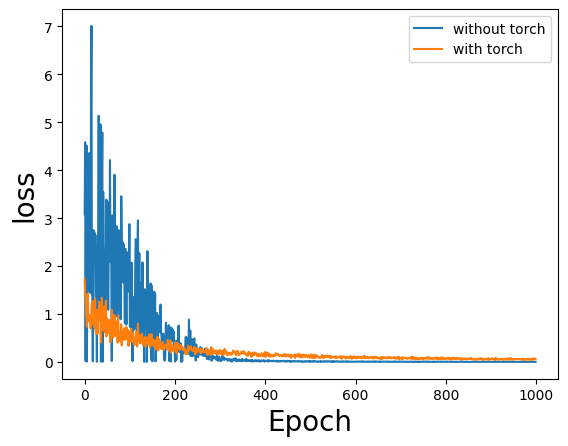

In [569]:
plt.plot(range(1000),np.abs(losses[:1000]),label = "without torch")
plt.plot(range(1000),losses_w_torch[:1000],label = "with torch")
plt.xlabel("Epoch",fontsize = 20)
plt.ylabel("loss",fontsize = 20)
plt.legend()
plt.show()

Problem2 : Implementation w/ torch
==========

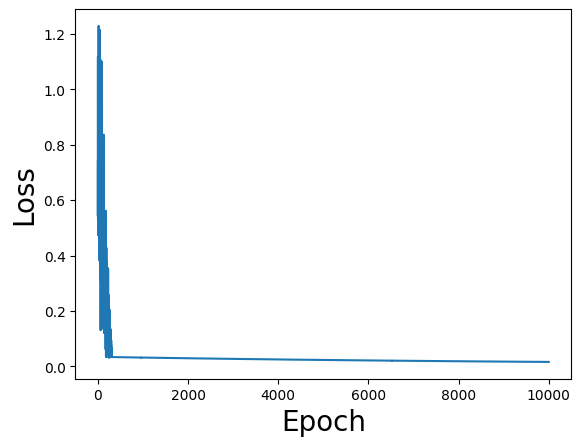

In [572]:
import numpy as np
import torch
import torch.nn as nn
from random import randint
import matplotlib.pyplot as plt
# Hyperparameters setup and Prepare Dataset
N,p = 30,20
np.random.seed(0)
X = np.random.randn(N,p)
Y = 2*np.random.randint(2,size = N)-1
lr = 3e-5
epoch = 10000
regularizer = 0.1 # lambda
batch_size = 8

class SVM(nn.Module):
    def __init__(self,input_dim = p):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, bias = True)
    
    def forward(self, x):
        return self.linear(x)

model = SVM()
optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
svm_losses = []

for _ in range(epoch) :
    tmp_losses = []
    for _ in range(batch_size):
        # Sampling
        idx = randint(0, (N-1)//batch_size)
        input, label = X[idx*batch_size : (idx+1)*batch_size], Y[idx*batch_size : (idx+1)*batch_size]
        
        input = torch.FloatTensor(input)
        label = torch.FloatTensor(label)

        output = model(input)

        optimizer.zero_grad()

        train_loss = torch.clamp(1-label@output,min = 0) + regularizer*model.linear.weight@model.linear.weight.T
        train_loss.requires_grad_(True)
        tmp_losses.append(train_loss)
        train_loss.backward() # calculate graident via backpropagation
        optimizer.step() # update the parameteres
    svm_losses.append(np.mean([x.detach().numpy() for x in tmp_losses]))

plt.plot(range(epoch), svm_losses)
plt.xlabel("Epoch",fontsize = 20)
plt.ylabel("Loss",fontsize = 20)
plt.show()
losses_torch = svm_losses

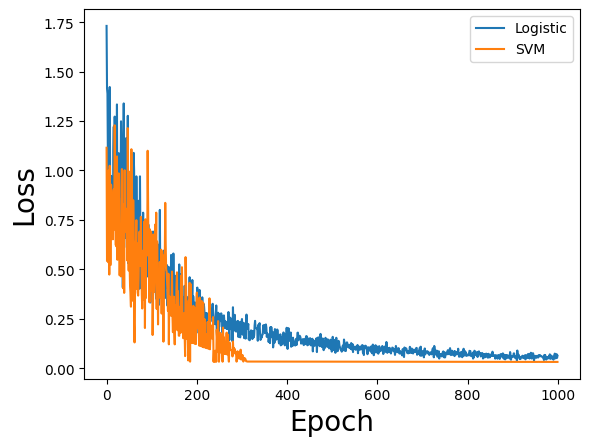

In [573]:
plt.plot(range(1000),losses_w_torch[:1000],label = "Logistic")
plt.plot(range(1000),svm_losses[:1000],label = "SVM")
plt.xlabel("Epoch",fontsize= 20)
plt.ylabel("Loss",fontsize= 20)
plt.legend()

Problem2 : Implementation w/o torch
==========

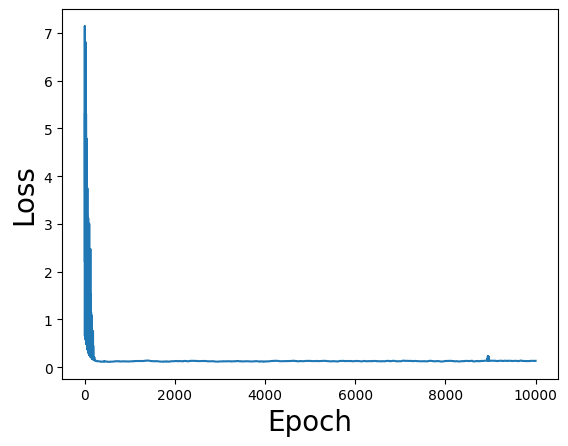

In [576]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt

# Hyperparameters setup and Prepare Dataset
N,p = 30,20
np.random.seed(0)
X = np.random.randn(N,p)
Y = 2*np.random.randint(2,size = N)-1
lr = 2e-3
epoch = 10000
regularizer = 0.1 # lambda
batch_size = 8

class SVM():
    def __init__(self,input_dim = p):
        self.weight = np.random.uniform(0,1,input_dim+1) # last row is bias term
        self.regularizer =regularizer
    def output(self,x):
        return x@self.weight
    def update_weight(self,grad,lr = 1e-4):
        self.weight = self.weight - lr * grad

    def loss_function(self, x, y):
        z = 1 - y * self.output(x)
        hinge_loss = np.clip(1-label@output,a_min = 0,a_max = None)  # element-wise maximum
        reg = self.regularizer * self.weight.T@self.weight  # regularization term

        return np.mean(hinge_loss) + reg

model = SVM()
svm_losses = []

for _ in range(epoch):
    tmp_loss = []
    for _ in range(batch_size):
        idx = randint(0,(N-1)//batch_size)
        input,label = X[idx*batch_size : (idx + 1)*batch_size], Y[idx*batch_size : (idx + 1)*batch_size]

        input = np.hstack([input,np.ones((input.shape[0],1))]) # add dummy for bias term

        output = model.output(input)
        train_loss = model.loss_function(input,label)

        grad = np.zeros((batch_size,p+1))
        for i in range(input.shape[0]):
            tmp_input = input[i]
            tmp_output = output[i]
            tmp_label = label[i]
            if tmp_label*tmp_output<1:
                grad[i] = -tmp_label*tmp_input

        idx = randint(0,batch_size-1)
        grad = grad[idx]
        grad += 2*regularizer*model.weight

        tmp_loss.append(train_loss)
        
        model.update_weight(grad=grad, lr = lr)
    svm_losses.append(np.mean(tmp_loss))

plt.plot(range(epoch), np.abs(svm_losses))
plt.xlabel("Epoch",fontsize = 20)
plt.ylabel("Loss",fontsize = 20)
plt.show()

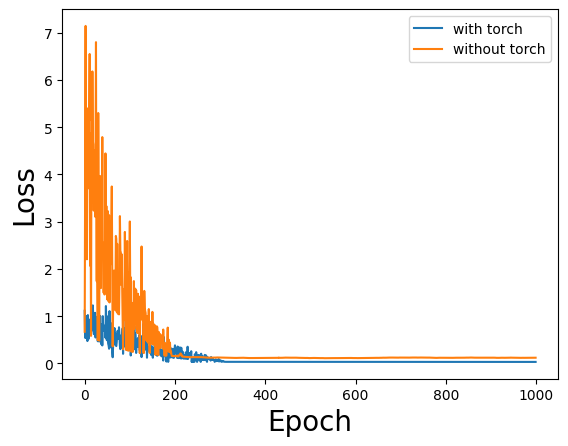

In [577]:
plt.plot(range(1000),losses_torch[:1000],label = "with torch")
plt.plot(range(1000),np.abs(svm_losses[:1000]),label = "without torch")

plt.xlabel("Epoch",fontsize = 20)
plt.ylabel("Loss",fontsize = 20)
plt.legend()
plt.show()

Problem3 : Implementation
========

In [457]:
N = 30
np.random.seed(0)
X = np.random.randn(2,N)
y = np.sign(X[0,:]**2 + X[1,:]**2 - 0.7)
theta = 0.5
c,s = np.cos(theta), np.sin(theta)
X = np.array([[c,-s],[s,c]])@X
X += np.array([[1],[1]])


Not Linearly Separable
---------

red for y = 1 and blue for y = -1


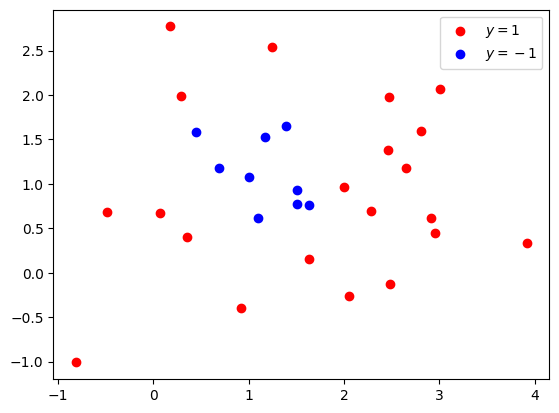

In [459]:
for i in range(N):
    if y[i] == 1:
        plt.scatter(X[0,i],X[1,i],color = "red")
    if y[i] == -1:
        plt.scatter(X[0,i],X[1,i],color = "blue")
plt.legend(["$y = 1$","$y = -1$"])
plt.show()


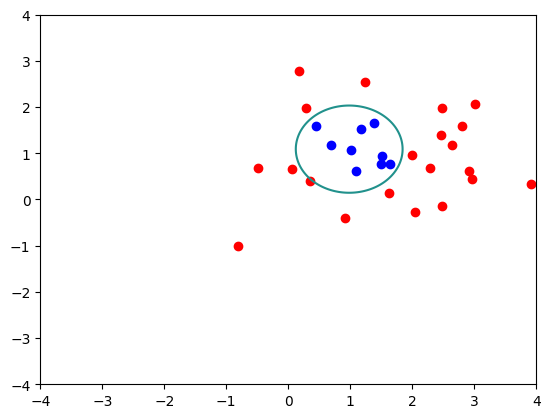

In [357]:
def trans(x):
    return [1,x[0],x[0]**2, x[1],x[1]**2]
X_trans = np.asarray([trans(x) for x in X.T]).T # (5,N)

import numpy as np
from random import randint
import matplotlib.pyplot as plt

N,p = 30,5
lr = 1e-3
epoch = 500
regularizer = 0.1 # lambda

class SVM():
    def __init__(self,input_dim = p):
        self.weight = np.random.uniform(0,1,input_dim+1) # last row is bias term
        self.regularizer =regularizer
    def output(self,x):
        return x.T@self.weight
    def update_weight(self,grad,lr = 1e-4):
        self.weight = self.weight - lr * grad

    def loss_function(self, x, y):
        x = np.append(x,y)
        return np.max([0, 1-y*self.output(x)]) + self.weight@self.weight.T *regularizer
    
    def loss_prime(self, x,y):
        x = np.append(x,y)
        if y*self.output(x) <1 : 
            return -y*x +2*self.regularizer*self.weight
        else:
            return 2*self.regularizer*self.weight

model = SVM()
svm_losses = []
cnt = 0

for _ in range(epoch):
    tmp_loss = []
    for _ in range(p):
        idx = randint(0,N-1)
        input,label = X_trans.T[idx], y[idx]
        z = model.output(np.append(input,label))
        train_loss = model.loss_function(input, label)
        tmp_loss.append(train_loss)
        grad = model.loss_prime(input,label)
        
        model.update_weight(grad=grad, lr = lr)
    svm_losses.append(np.mean(tmp_loss))

w = model.weight
xx = np.linspace(-4,4,1024)
yy = np.linspace(-4,4,1024)
xx,yy = np.meshgrid(xx,yy)
Z = w[0] + (w[1]*xx + w[2]*xx**2) +(w[3]*yy + w[4]*yy**2)
plt.contour(xx,yy,Z,0)
for i in range(N):
    if y[i] == 1:
        plt.scatter(X[0,i],X[1,i],color = "red")
    if y[i] == -1:
        plt.scatter(X[0,i],X[1,i],color = "blue")
plt.show()

Problem 7 : Implementation
==========

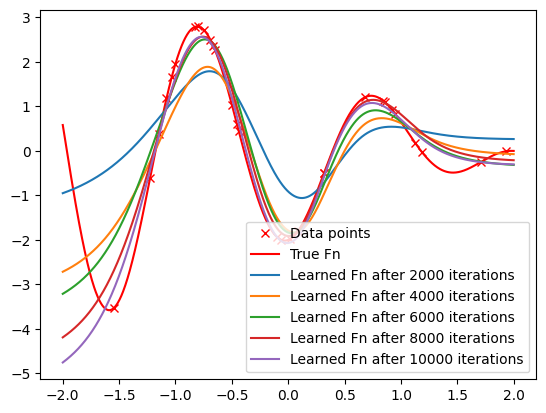

<Figure size 640x480 with 0 Axes>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def f_true(x) :
    return (x-2)*np.cos(x*4)

def sigmoid(x) :
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x) :
    return sigmoid(x) * (1 - sigmoid(x))

K = 10000
alpha = 0.007
N, p = 30, 50
np.random.seed(0)
a0 = np.random.normal(loc = 0.0, scale = 4.0, size = p)
b0 = np.random.normal(loc = 0.0, scale = 4.0, size = p)
u0 = np.random.normal(loc = 0, scale = 0.05, size = p)
theta = np.concatenate((a0,b0,u0))
losses =[]
tmp_losses = []

X = np.random.normal(loc = 0.0, scale = 1.0, size = N)
Y = f_true(X)

def f_th(theta, x) :
    return np.sum(theta[2*p : 3*p] * sigmoid(theta[0 : p] * np.reshape(x,(-1,1)) + theta[p : 2*p]), axis=1)

def diff_f_th(theta, x) :
    a = theta[:p]
    b = theta[p:2*p]
    u = theta[2*p:]
    return np.append(np.append(np.diag(sigmoid_prime(a*x+b))@u*x, np.diag(sigmoid_prime(a*x+b))@u), sigmoid(a*x+b))

xx = np.linspace(-2,2,1024)
plt.plot(X,f_true(X),'rx',label='Data points')
plt.plot(xx,f_true(xx),'r',label='True Fn')

for k in range(K) :
    idx = np.random.randint(0,N-1)
    input, label = X[idx], Y[idx]
    loss = (f_th(theta,input) - label)**2/2
    tmp_losses.append(loss)
    theta = theta - alpha*(f_th(theta,input) - label) * diff_f_th(theta,input)
    
    if (k+1)%2000 == 0 :
        plt.plot(xx,f_th(theta, xx),label=f'Learned Fn after {k+1} iterations')

    if (k+1)%p == 0:
        losses.append(np.mean(tmp_losses))
        tmp_losses = []

plt.legend()
plt.show()
plt.savefig('plot.png')


Text(0, 0.5, 'Loss')

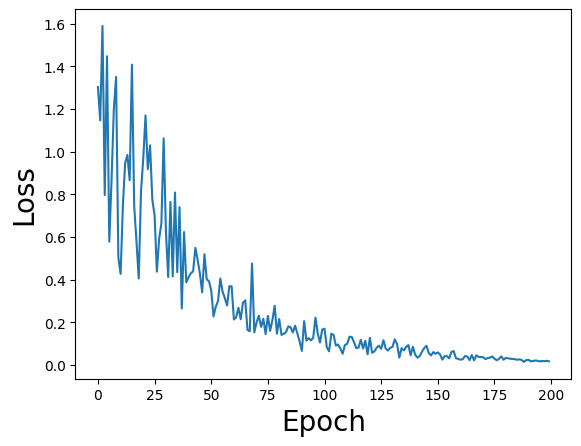

In [3]:
plt.plot(range(200),losses)
plt.xlabel("Epoch",fontsize = 20)
plt.ylabel("Loss",fontsize = 20)